# Kaggle Dogs vs Cats Library and Demo

This is a library to download and parse the [Kaggle's Dogs vs Cats competition](https://www.kaggle.com/competitions/dogs-vs-cats/overview) dataset and a demo of CNNs.

It's inspired on [Keras' Image classification from scratch](https://keras.io/examples/vision/image_classification_from_scratch/) demo.

## Environment Set Up

Let's set up `go.mod` to use the local copy of GoMLX, so it can be developed jointly the dataset code with the model. That's often how data pre-processing and model code is developed together with experimentation.

If you are not changing GoMLX code, feel free to simply skip this cell. Or if you used a different directory for you projects, change it below.

Notice the directory `${HOME}/Projects/gomlx` is where the GoMLX code is copied by default in [its Docker](https://hub.docker.com/repository/docker/janpfeifer/gomlx_jupyterlab/general).

In [1]:
!*go mod edit -replace github.com/gomlx/gomlx="${HOME}/Projects/gomlx"

## Data Preparation

The dataset takes ~790Mb compressed, and contains ~25K examples (a few are not parseable JPG), evenly split. We further separate this into 20K for training and 5K for validation/testing, randomly picked. 

GoMLX provides a dataset loading and data augmentation [library for the Kaggle Dogs vs Cats competition](https://pkg.go.dev/github.com/gomlx/gomlx@v0.1.0/examples/dogsvscats#section-readme). 
This make it easy to acess the data -- but this notebook serves as documentation and example for the library.

Let's first create the train/validation dataset, and display a sample of the augmented images. The `dogsvscats` library provide a `dogsvscats.CreateDatasets`
function that takes a `dogsvscats.Configuration` and returns 3 datasets: one for training; one for evaluation on training data; one for evaluation on a validation (separate) data. Only the training data is augmented, and we use that in the cell below to sample from -- you'll notice some random rotations, and images are randomly flipped.

The first time it runs it may take a while, since it needs to download the data from the internet. The default directory for the data is `${HOME}/tmp/dogs_vs_cats/`, but you can change it, by setting the `--data` flag. The next time it runs it will re-use the downloaded data.

In [2]:
import (
    "github.com/gomlx/gomlx/ml/data"
    "github.com/gomlx/gomlx/examples/dogsvscats"
)

var (
    flagModelType      = flag.String("model", "cnn", "Model types: \"cnn\", \"inception\" or \"byol\"")
    flagDataDir   = flag.String("data", "~/work/dogs_vs_cats", "Directory to cache downloaded and generated dataset files.")
    flagBatchSize = flag.Int("batch", dogsvscats.DefaultConfig.BatchSize, "Batch size for training")

    flagAugment      = flag.Bool("augment", true, "Whether to augment the data during training or sampling. Evaluation is never augmented.")
    flagAngleStdDev  = flag.Float64("angle", 20.0, "Standard deviation of noise used to rotate the image. Disabled if --augment=false.")
    flagFlipRandomly = flag.Bool("flip", true, "Randomly flip the image horizontally. Disabled if --augment=false.")
    flagForceOriginal = flag.Bool("force_original", false, "Set to true to use original images and dynamically read and augment images.")

	flagByolUsePairs            = flag.Bool("byol_use_pairs", true, "BYOL trained on pairs of images.")
)

// AssertNoError `log.Fatal` if err is not nil.
func AssertNoError(err error) {
    if err != nil {
        log.Fatalf("Failed: %+v", err)
    }
}

// buildConfig uses flags to build configurations object.
func buildConfig() (config *dogsvscats.Configuration) {
    *flagDataDir = data.ReplaceTildeInDir(*flagDataDir)
    if !data.FileExists(*flagDataDir) {
        AssertNoError(os.MkdirAll(*flagDataDir, 0777))
    }

    config = &dogsvscats.Configuration{}
    *config = *dogsvscats.DefaultConfig  // Initialize with defaults.
    config.DataDir = *flagDataDir
    if !*flagAugment {
        *flagAngleStdDev = 0  // Disable angle augmentation.
        *flagFlipRandomly = false  // Disable random flipping
    }
    config.AngleStdDev = *flagAngleStdDev
    config.FlipRandomly = *flagFlipRandomly
    config.BatchSize = *flagBatchSize
    config.ForceOriginal = *flagForceOriginal
    config.UseParallelism = true
    config.BufferSize = 100
	config.YieldImagePairs = *flagModelType == "byol" && *flagByolUsePairs
    return
}

%%
config := buildConfig()

// Download dataset, if not yet downloaded.
AssertNoError(dogsvscats.Download(config.DataDir))


Now that the data is downloaded we can create a `train.Dataset` and sample from it. We sample a few images and display below.

Dog (11142),Dog (1546),Dog (5622),Dog (7875)
Cat (4399),Cat (3379),Cat (2569),Cat (12117)

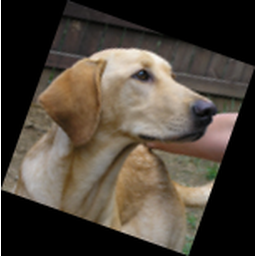
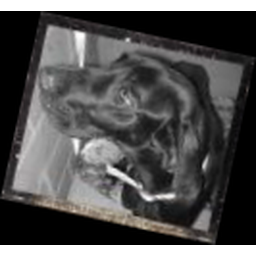
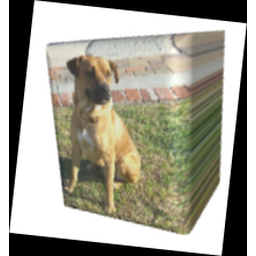
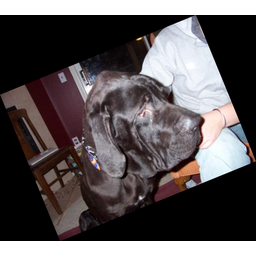
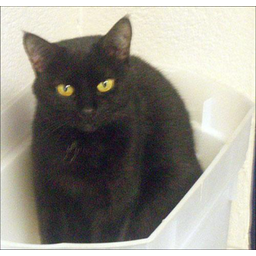
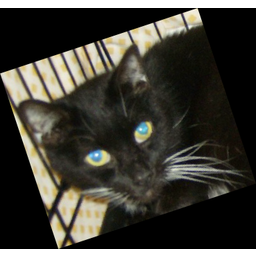
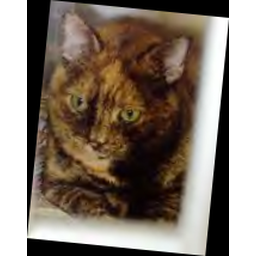
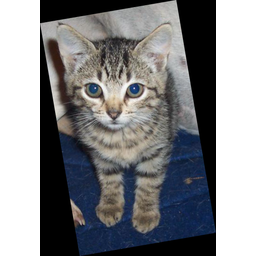

In [3]:
import(
    timage "github.com/gomlx/gomlx/types/tensor/image"
    "github.com/gomlx/gomlx/types/tensor"
    "github.com/gomlx/gomlx/ml/data"

    "github.com/janpfeifer/gonb/gonbui"
)

// sample some random augmented images and display them in the Notebook.
func sample(config *dogsvscats.Configuration, numRows, numPerRow int) {
    var images []image.Image
    var labels []dogsvscats.DorOrCat
    var err error

    // Create datasets with batch size equals 2*numPerRow.
    var configForSample dogsvscats.Configuration
    configForSample = *config
    configForSample.BatchSize = numRows*numPerRow  // Sample only what we need, in one batch.
    configForSample.ModelImageSize = 256
    configForSample.ForceOriginal = true
    configForSample.UseParallelism = true
    configForSample.DType = shapes.UInt8
    
    // Sample the images.
    ds, _, _ := dogsvscats.CreateDatasets(&configForSample)
    _, inputsT, labelsT, err := ds.Yield()
    AssertNoError(err)
    
    // Get indices and labels of the images.
    indices := inputsT[1].Local().Value().([]int)
    labelsFloat := labelsT[0].Local().Value().([]uint8)
    labels = make([]dogsvscats.DorOrCat, 0, numRows*numPerRow)
    for _, labelFloat := range labelsFloat {
        labels = append(labels, dogsvscats.DorOrCat(labelFloat))
    }
    
    // Convert images from tensor to Go images.
    images, err = timage.ToImage().Batch(inputsT[0].Local())

    htmlRows := make([]string, 0, numRows)
    count := 0
    for row := 0; row < numRows; row++ {
        cells := make([]string, 0, numPerRow)
        for col := 0; col < numPerRow; col++ {
            imgIdx := indices[count]
            cells = append(cells, embedImageInHTML(images[count], labels[count].String(), imgIdx, 256))
            count++
        }
        htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
    }
    htmlTable := fmt.Sprintf("<h3>%s</h3><table>%s</table>\n", "Sample Dogs vs Cats", strings.Join(htmlRows, ""))
    gonbui.DisplayHTML(htmlTable)
}

// embedImageInHTML, with a label.
func embedImageInHTML(img image.Image, label string, imgIdx int, size int) string {
    imgSrc, err := gonbui.EmbedImageAsPNGSrc(img)   // Generate image in-html (in the src filed), as opposed to a separate file.
    AssertNoError(err)
    return fmt.Sprintf(`<figure style="padding:4px;text-align: center; background-color: lightgray; color: black;"><img src="%s" width="%dpx" height="%dpx"><figcaption style="text-align: center;">%s (%d)</figcaption></figure>`,
                       imgSrc, size, size, label, imgIdx)
}

%%
config := buildConfig()
sample(config, 2, 4)

### Pre-Generating Agumented and Scaled Images

While our dataset does parallelize the work of augmenting and scaling the images, it's still bottlenecked mostly by the transformation than by the machine learning (at least if running in an old GPU). 

So an alternative is pre-generating the augmented and scaled images, which takes space in disk, but will significantly accelerate training. 

The `gomlx/examples/dogsvscats` library provides the `PreGenerate(config *Configuration, numEpochsForTraining int)` function that does that. It will take some 10 minutes to generate 50 epochs of augmented data (~1M uniquely augmented images, or ~30000 unique batches of size 32), which is plenty to train, but takes 22Gb of space. The function `dogsvscats.CreateDatasets` will automatically use the pre-generated data if it find the files in the `--data` directory.

> **Note**: one issue with the pre-generated dataset (as its currently implemented) is that it's not shuffable: so if 
> one restarts training without going over all the 40 epochs it will see the same images over and over and will overfit to them.

This can take up to 10 minutes, but only needs to be run once. If it detects the files already exist, it's just skipped.

In [4]:
import (
    "github.com/gomlx/gomlx/ml/data"
    "github.com/gomlx/gomlx/ml/train"
)

// We increase the size of the batch for the generation of images -- it makes it a bit faster.
%% --batch=100

repeats := 50
config := buildConfig()
dogsvscats.PreGenerate(config, repeats, false)

// Report on number of records from each dataset -- we need to read through them.
fmt.Println("")
for dsIdx, dsName := range []string{dogsvscats.PreGeneratedTrainFileName, dogsvscats.PreGeneratedTrainEvalFileName, dogsvscats.PreGeneratedValidationFileName} {
    fmt.Printf("Dataset %q: ... \r", dsName)
    dsPath := path.Join(config.DataDir, dsName)
    ds := dogsvscats.NewPreGeneratedDataset(dsName, dsPath, 1, false, config.ModelImageSize, config.ModelImageSize, config.DType)
    count := 0
    for {
        if _, _, _, err := ds.Yield(); err != nil { break }
        count++
    }
    if dsIdx == 0 { // For train data, where we generate multiple augmented versions of the original image.
        fmt.Printf("Dataset %q: %d images (== %d x %d)\n", dsName, count, repeats, count/repeats)    
    } else {
        fmt.Printf("Dataset %q: %d images\n", dsName, count)    
    }
}

Validation data for evaluation already generated in "/home/jupyter/work/dogs_vs_cats/validation_eval_data.bin"
Training data for evaluation already generated in "/home/jupyter/work/dogs_vs_cats/train_eval_data.bin"
Training data for training already generated in "/home/jupyter/work/dogs_vs_cats/train_data.bin"

Dataset "train_data.bin": 1009400 images (== 50 x 20188)
Dataset "train_eval_data.bin": 20188 images
Dataset "validation_eval_data.bin": 4798 images


## Training a CNN model

Our model is a simple CNN model currently using images scaled down to 75x75 pixels, with random rotations (mean 0 and standard deviation of 5 degrees) and random flips.

### Model Flags

Defined in one place for all models, because many are used accross the training loop.

In [5]:
import (
    "flag"
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/graph/nanlogger"
    "github.com/gomlx/gomlx/ml/context"
)

var (
	flagNanLogger      = flag.Bool("nanlogger", false, "Set to enable logging of NaN values, as soon as they happen.")

    // Training hyperparameters:
    flagOptimizer        = flag.String("optimizer", "adamw", fmt.Sprintf("Optimizer, options: %q", slices.SortedKeys(optimizers.KnownOptimizers)))
    flagLearningRate     = flag.Float64("learning_rate", 0.0001, "Initial learning rate.")
    flagL2Regularization = flag.Float64("l2_reg", 0, "L2 regularization on kernels. It doesn't interact well with --batch_norm.")
    flagUnsupervised = flag.Bool("unsupervised", false, "Train only regularization and don't use labels.")
    flagNormalization    = flag.String("norm", "layer", fmt.Sprintf("Type of layer normalization to use. Valid values: %q.", slices.SortedKeys(layers.KnownNormalizers)))

    // CNN and FNN that follows.
    flagNumConvolutions = flag.Int("num_convolutions", 5, "Number of convolutions -- there will be at least as many to reduce the image to 16x16")
    flagConvDropout     = flag.Float64("conv_dropout", 0, "Amount of dropout in the convolution layers. 0 means no dropout.")
    flagNumHiddenLayers = flag.Int("hidden_layers", 3, "Number of hidden layers, stacked with residual connection.")
    flagNumNodes        = flag.Int("num_nodes", 128, "Number of nodes in hidden layers.")

	// BYOL model parameters:
	flagByolProjectionNumLayers = flag.Int("byol_hidden_layers", 2, "When using \"byol\" model, this is the number of layers in the projection to the target regularizing model.")
	flagByolProjectionNumNodes  = flag.Int("byol_num_nodes", 128, "When using \"byol\" model, this is the number of nodes (dimension) in the projection to the target regularizing model.")
	flagByolTargetUpdateRatio   = flag.Float64("byol_target_update_ratio", 0.99, "Moving average update weight to the \"target\" sub-model for BYOL model.")
	flagByolRegularizationRate  = flag.Float64("byol_regularization_rate", 33.0, "BYOL regularization loss rate, a simple multiplier.")
	flagByolInception           = flag.Bool("byol_inception", false, "Insted of using a CNN model with BYOL, uses InceptionV3.")
)

var (
    manager = NewManager()
    nanLogger *nanlogger.NanLogger
)

// NewContext returns context with parameters set for flags. 
// Contexts hold the variables and hyperparameters for the model.
func NewContext() *context.Context {
    ctx := context.NewContext(manager)
    ctx.SetParam("optimizer", *flagOptimizer)  // Just so it is saved along with the context.    
    ctx.SetParam(optimizers.LearningRateKey, *flagLearningRate)
    ctx.SetParam(layers.L2RegularizationKey, *flagL2Regularization)
    ctx.SetParam("normalization", *flagNormalization)
    ctx.SetParam("num_convolutions", *flagNumConvolutions)
    ctx.SetParam("hidden_layers", *flagNumHiddenLayers)
    ctx.SetParam("num_nodes", *flagNumNodes)
	ctx.SetParam("conv_dropout", *flagConvDropout)

    // BYOL model parameters.
	if *flagModelType == "byol" {
		ctx.SetParam("byol_hidden_layers", *flagByolProjectionNumLayers)
		ctx.SetParam("byol_num_nodes", *flagByolProjectionNumNodes)
		ctx.SetParam("byol_target_update_ratio", *flagByolTargetUpdateRatio)
		ctx.SetParam("byol_use_pairs", *flagByolUsePairs)
		ctx.SetParam("byol_regularization_rate", *flagByolRegularizationRate)
		ctx.SetParam("byol_inception", *flagByolInception)
	}

    if *flagNanLogger {
		nanLogger = nanlogger.New()
	}
    return ctx
}

### Model Definition

Let's build the model function, and check that we get the right shape in the output.

We use normalization since it speeds up (and improves) the training. Notice the normalization axes are different when normalizing for images or flat features.

In [6]:
import (
    "fmt"    
    "github.com/gomlx/gomlx/graph/nanlogger"
    . "github.com/gomlx/gomlx/types/exceptions"
    "github.com/gomlx/gomlx/types/shapes"
    "github.com/gomlx/gomlx/types/slices"
    "github.com/gomlx/gomlx/ml/layers"
)

func normalizeImage(ctx *context.Context, x *Node) *Node {
    x.AssertRank(4) // [batch_size, width, height, depth]
    norm := context.GetParamOr(ctx, "normalization", "none")
    switch norm {
    case "layer":
        return layers.LayerNormalization(ctx, x, 1, 2).ScaleNormalization(false).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    Panicf("invalid normalization selected %q -- valid values are batch, layer, none", norm)
    return nil
}

func normalizeFeatures(ctx *context.Context, x *Node) *Node {
    x.AssertRank(2) // [batch_size, embedding_dim]
    norm := context.GetParamOr(ctx, "normalization", "none")
    switch norm {
    case "layer":
        return layers.LayerNormalization(ctx, x, -1).Done()
    case "batch":
        return layers.BatchNormalization(ctx, x, -1).Done()
    case "none":
        return x
    }
    Panicf("invalid normalization selected %q -- valid values are batch, layer, none", norm)
    return nil
}

// CnnModelGraph builds the CNN model for our demo.
// It returns the logit, not the predictions, which works with most losses.
// inputs: only one tensor, with shape `[batch_size, width, height, depth]`.
func CnnModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
	logit, _ := CnnModelWithEmbedding(ctx, inputs[0])
	return []*Node{logit} // Return only the logits.
}

// CnnModelWithEmbedding builds a CNN model and return the final logit of the binary classification and the last layer embeddings.
func CnnModelWithEmbedding(ctx *context.Context, images *Node) (logit, embedding *Node) {
	numConvolutions := context.GetParamOr(ctx, "num_convolutions", 5)
	dropoutRate := context.GetParamOr(ctx, "conv_dropout", 0.0)
	var dropoutNode *Node
	if dropoutRate > 0.0 {
		dropoutNode = Scalar(images.Graph(), images.DType(), dropoutRate)
	}

	filterSize := 16
	batchSize := images.Shape().Dimensions[0]
	logits := images
	imgSize := images.Shape().Dimensions[1]
	for convIdx := 0; convIdx < numConvolutions && imgSize > 16; convIdx++ {
		ctx := ctx.In(fmt.Sprintf("conv_%d", convIdx))
		if convIdx > 0 {
			logits = normalizeImage(ctx, logits)
		}
		for repeat := 0; repeat < 2; repeat++ {
			ctx := ctx.In(fmt.Sprintf("repeat_%d", repeat))
			residual := logits
			logits = layers.Convolution(ctx, logits).Filters(filterSize).KernelSize(3).PadSame().Done()
			logits = layers.Relu(logits)
			if dropoutNode != nil {
				logits = layers.Dropout(ctx, logits, dropoutNode)
			}
			if residual.Shape().Eq(logits.Shape()) {
				logits = Add(logits, residual)
			}
		}
		if imgSize > 16 {
			// Reduce image size by 2 each time.
			logits = MaxPool(logits).Window(2).Done()
			imgSize /= 2
		}
		logits.AssertDims(batchSize, imgSize, imgSize, filterSize)
	}

	// Flatten the resulting image, and treat the convolved values as tabular.
	logits = Reshape(logits, batchSize, -1)
	logits = FnnOnTop(ctx, logits)
	embedding = logits
	logit = layers.DenseWithBias(ctx.In("readout"), logits, 1)
	return
}

// FnnOnTop adds a feedforward neural network on top of the CNN layer and returns the "embedding" of the last layer.
func FnnOnTop(ctx *context.Context, logits *Node) *Node {
	numHiddenLayers := context.GetParamOr(ctx, "hidden_layers", 3)
	numNodes := context.GetParamOr(ctx, "num_nodes", 3)
	for ii := 0; ii < numHiddenLayers; ii++ {
		ctx := ctx.In(fmt.Sprintf("dense_%d", ii))
		residual := logits
		// Add layer with residual connection.
		logits = layers.Relu(logits)
		logits = layers.DenseWithBias(ctx, logits, numNodes)
		logits = normalizeFeatures(ctx, logits)
		if ii >= 1 {
			logits = Add(logits, residual)
		}
	}
	return logits
}

%%
config := buildConfig()
ctx := NewContext()

// Let's just check that we get the right shape from the model function, wihtout any real data.
graph := manager.NewGraph("test")
inputs := []*Node{
    // Images: create a graph parameter node shaped [batch_size, width, heigh, depth=4]:
    graph.Parameter("images", shapes.Make(config.DType, config.BatchSize, config.ModelImageSize, config.ModelImageSize, 4)),
}
outputs := CnnModelGraph(ctx, nil, inputs)
fmt.Printf("Logits shape for batch_size=%d: %s\n", config.BatchSize, outputs[0].Shape())

Logits shape for batch_size=32: (Float32)[32 1]


### Training Loop

Next let's build the training loop, and train for a few steps to see that everything is ok.

First, we want to support multiple model types. We'll introduce the Inception's based model type later:

In [7]:
import (
    "flag"
    "fmt"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/ml/train"
    "github.com/gomlx/gomlx/types/slices"
)

var (
    modelTypeToModelFn = map[string]train.ModelFn{
        "cnn": CnnModelGraph,
        // "inception" and "byol" models will be included below.
    }
)

// selectModelFn according to flag.
func selectModelFn() (modelFn train.ModelFn) {
    modelFn, found := modelTypeToModelFn[*flagModelType]
    if !found {        
        AssertNoError(fmt.Errorf("Unknown model type --model=%q -- only %q are supported", 
                                 *flagModelType, slices.SortedKeys(modelTypeToModelFn)))
    }
    return
}
%%

We add the following functionality to our training loop below:

- Mean accuracy and moving average accuracy metrics.
- Checkpointing (`--checkpoint_keep` times in loop).
- A progressbar.
- Plot of all metrics using [Margaid](https://github.com/erkkah/margaid), updated dynamically as training is going on. Controlled by `--plot_points`.



In [8]:
import (
    "path"
    
    . "github.com/gomlx/gomlx/graph"
    "github.com/gomlx/gomlx/examples/notebook/gonb/margaid"
    "github.com/gomlx/gomlx/ml/train"
    "github.com/gomlx/gomlx/types/tensor"
)

var (
    flagNumSteps       = flag.Int("steps", 2000, "Number of gradient descent steps to perform")
    flagCheckpoint     = flag.String("checkpoint", "", "Directory save and load checkpoints from. If left empty, no checkpoints are created.")
    flagCheckpointKeep = flag.Int("checkpoint_keep", 10, "Number of checkpoints to keep, if --checkpoint is set.")
    flagPlots          = flag.Bool("plots", true, "Plots during training: perform periodic evaluations, "+
                                   "save results if --checkpoint is set and draw plots, if in a Jupyter notebook.")
)

func trainModel(config *dogsvscats.Configuration) {
    trainDS, trainEvalDS, validationEvalDS := dogsvscats.CreateDatasets(config)

    // Metrics we are interested.
    meanAccuracyMetric := metrics.NewMeanBinaryLogitsAccuracy("Mean Accuracy", "#acc")
    movingAccuracyMetric := metrics.NewMovingAverageBinaryLogitsAccuracy("Moving Average Accuracy", "~acc", 0.01)

    ctx := NewContext()

    // Checkpoint: it loads if already exists, and it will save as we train.
    var checkpoint *checkpoints.Handler
    if *flagCheckpoint != "" {
        var err error
        checkpoint, err = checkpoints.Build(ctx).
            DirFromBase(*flagCheckpoint, config.DataDir).
            Keep(*flagCheckpointKeep).Done()
        AssertNoError(err)
    	globalStep := optimizers.GetGlobalStep(ctx)
    	if globalStep != 0 {
    		fmt.Printf("> restarting training from global_step=%d\n", globalStep)
    	}
    }

    
    // Select the model type we are using:
    modelFn := selectModelFn()

    lossFn := losses.BinaryCrossentropyLogits
    if *flagUnsupervised {
        lossFn = losses.Zero
    }
    // Create a train.Trainer: this object will orchestrate running the model, feeding
    // results to the optimizer, evaluating the metrics, etc. (all happens in trainer.TrainStep)
    trainer := train.NewTrainer(manager, ctx, modelFn,
        lossFn,
        optimizers.MustOptimizerByName(*flagOptimizer),
        []metrics.Interface{movingAccuracyMetric}, // trainMetrics
        []metrics.Interface{meanAccuracyMetric})   // evalMetrics
    nanLogger.AttachToTrainer(trainer)

    // Use standard training loop.
    loop := train.NewLoop(trainer)
    commandline.AttachProgressBar(loop) // Attaches a progress bar to the loop.

    // Attach a checkpoint: checkpoint every 1 minute of training.
    if checkpoint != nil {
        period := time.Minute * 1
        train.PeriodicCallback(loop, period, true, "saving checkpoint", 100,
            func(loop *train.Loop, metrics []tensor.Tensor) error {
                // fmt.Printf("\n[saving checkpoint@%d] [median train step (ms): %d]\n", loop.LoopStep, loop.MedianTrainStepDuration().Milliseconds())
                return checkpoint.Save()
            })
    }

    // Attach a margaid plots: plot points at exponential steps.
    // The points generated are saved along the checkpoint directory (if one is given).
    var plots *margaid.Plots
    if *flagPlots {
        plots = margaid.NewDefault(loop, checkpoint.Dir(), 100, 1.1, trainEvalDS, validationEvalDS).
            			WithEvalLossType("eval-loss")
    }

    // Loop for given number of steps.
    _, err := loop.RunSteps(trainDS, *flagNumSteps)
    AssertNoError(err)
    fmt.Printf("\t[Step %d] median train step: %d microseconds\n",
        loop.LoopStep, loop.MedianTrainStepDuration().Microseconds())

    // Finally, print an evaluation on train and test datasets.
    fmt.Println()
    err = commandline.ReportEval(trainer, trainEvalDS, validationEvalDS)
    if plots != nil {
        plots.Done()
    }
    AssertNoError(err)
    fmt.Println()
}

// InceptionV3ModelGraph is a placeholder, we'll define it later.
func InceptionV3ModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    return nil
}

%% --steps=100 --plots=false --batch=32
config := buildConfig()
config.ForceOriginal = false
trainModel(config)

Training (100 steps):  100% [========================================] (34 steps/s) [loss=0.661] [~loss=0.697] [~acc=54.53%]         
	[Step 100] median train step: 3992 microseconds

Results on train-eval [Pre]:
	Mean Loss (#loss): 0.679
	Mean Accuracy (#acc): 57.60%
Results on valid-eval [Pre]:
	Mean Loss (#loss): 0.680
	Mean Accuracy (#acc): 56.77%



### Training Session: CNN with 30K steps

In [9]:
!rm -rf ~/tmp/dogs_vs_cats/base_cnn

In [51]:
%% --batch=32 --steps=30000 --checkpoint=base_cnn
config := buildConfig()
trainModel(config)

Training (30000 steps):  100% [========================================] (187 steps/s) [loss=0.313] [~loss=0.314] [~acc=85.94%]          


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.612395e+01 L1.280695e+02,4.267562e+01 L1.957685e+02,5.317088e+01 L2.460232e+02,7.228050e+01 L2.867271e+02,7.581650e+01 L3.215770e+02,8.860642e+01 L3.523260e+02,8.315194e+01 L3.801574e+02,1.036910e+02 L4.058015e+02,9.838696e+01 L4.297353e+02,1.067380e+02 L4.522837e+02,1.272771e+02 L4.736765e+02,1.340106e+02 L4.941417e+02,1.477785e+02 L5.138351e+02,1.553020e+02 L5.328655e+02,1.613960e+02 L5.513095e+02,1.610199e+02 L5.692591e+02,1.740355e+02 L5.867754e+02,1.800919e+02 L6.039278e+02,1.864492e+02 L6.207595e+02,1.865621e+02 L6.373191e+02,1.940479e+02 L6.536341e+02,1.933332e+02 L6.697363e+02,2.025871e+02 L6.856409e+02,2.044679e+02 L7.013671e+02,2.060855e+02 L7.169350e+02,2.106372e+02 L7.323632e+02,2.169945e+02 L7.476679e+02,2.222610e+02 L7.628621e+02,2.269255e+02 L7.779555e+02,2.267374e+02 L7.929628e+02,2.341104e+02 L8.078924e+02,2.423487e+02 L8.227480e+02,2.440038e+02 L8.375415e+02,2.439662e+02 L8.522770e+02,2.486684e+02 L8.663200e+02,2.548000e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,3.443658e+01 L1.280695e+02,4.569781e+01 L1.957685e+02,5.422415e+01 L2.460232e+02,7.545952e+01 L2.867271e+02,7.771178e+01 L3.215770e+02,9.315573e+01 L3.523260e+02,7.529868e+01 L3.801574e+02,1.002342e+02 L4.058015e+02,8.672075e+01 L4.297353e+02,9.814282e+01 L4.522837e+02,1.156781e+02 L4.736765e+02,1.299959e+02 L4.941417e+02,1.370744e+02 L5.138351e+02,1.484965e+02 L5.328655e+02,1.542879e+02 L5.513095e+02,1.539662e+02 L5.692591e+02,1.634578e+02 L5.867754e+02,1.731102e+02 L6.039278e+02,1.785800e+02 L6.207595e+02,1.793843e+02 L6.373191e+02,1.809931e+02 L6.536341e+02,1.817975e+02 L6.697363e+02,1.932196e+02 L6.856409e+02,1.912890e+02 L7.013671e+02,1.972414e+02 L7.169350e+02,2.041590e+02 L7.323632e+02,2.048025e+02 L7.476679e+02,2.125245e+02 L7.628621e+02,2.125245e+02 L7.779555e+02,2.175115e+02 L7.929628e+02,2.220161e+02 L8.078924e+02,2.281293e+02 L8.227480e+02,2.313468e+02 L8.375415e+02,2.270031e+02 L8.522770e+02,2.353686e+02 L8.663200e+02,2.339208e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L1.280695e+02,2.924619e+01 L1.957685e+02,4.986066e+01 L2.460232e+02,7.248177e+01 L2.867271e+02,8.804547e+01 L3.215770e+02,9.710987e+01 L3.523260e+02,1.049456e+02 L3.801574e+02,1.051241e+02 L4.058015e+02,1.210775e+02 L4.297353e+02,1.278496e+02 L4.522837e+02,1.251494e+02 L4.736765e+02,1.426290e+02 L4.941417e+02,1.381779e+02 L5.138351e+02,1.565782e+02 L5.328655e+02,1.622386e+02 L5.513095e+02,1.605612e+02 L5.692591e+02,1.731200e+02 L5.867754e+02,1.704581e+02 L6.039278e+02,1.807836e+02 L6.207595e+02,1.858042e+02 L6.373191e+02,1.875731e+02 L6.536341e+02,1.921306e+02 L6.697363e+02,1.879189e+02 L6.856409e+02,1.967043e+02 L7.013671e+02,2.046593e+02 L7.169350e+02,2.083280e+02 L7.323632e+02,2.113596e+02 L7.476679e+02,2.154443e+02 L7.628621e+02,2.184881e+02 L7.779555e+02,2.246283e+02 L7.929628e+02,2.283532e+02 L8.078924e+02,2.338425e+02 L8.227480e+02,2.344785e+02 L8.375415e+02,2.392541e+02 L8.522770e+02,2.425946e+02 L8.663200e+02,2.428349e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.208102e+02,0 L1.208102e+02,-6 M1.811376e+02,0 L1.811376e+02,-6 M2.239405e+02,0 L2.239405e+02,-6 M2.571410e+02,0 L2.571410e+02,-6 M2.842678e+02,0 L2.842678e+02,-6 M3.072032e+02,0 L3.072032e+02,-6 M3.270707e+02,0 L3.270707e+02,-6 M3.445951e+02,0 L3.445951e+02,-6 M3.602712e+02,0 L3.602712e+02,-6 M3.744520e+02,0 L3.744520e+02,-6 M4.634015e+02,0 L4.634015e+02,-6 M5.237288e+02,0 L5.237288e+02,-6 M5.665317e+02,0 L5.665317e+02,-6 M5.997322e+02,0 L5.997322e+02,-6 M6.268590e+02,0 L6.268590e+02,-6 M6.497944e+02,0 L6.497944e+02,-6 M6.696619e+02,0 L6.696619e+02,-6 M6.871863e+02,0 L6.871863e+02,-6 M7.028624e+02,0 L7.028624e+02,-6 M8.059927e+02,0 L8.059927e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 "/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 20000 30000 Steps 0.600 0.700 0.800 accuracy accuracy metrics Eval on trai

<path d="M1.768000e+01,2.548000e+02 L1.280695e+02,2.446833e+02 L1.957685e+02,2.414909e+02 L2.460232e+02,2.290938e+02 L2.867271e+02,2.356826e+02 L3.215770e+02,2.188836e+02 L3.523260e+02,2.320758e+02 L3.801574e+02,2.048168e+02 L4.058015e+02,2.208230e+02 L4.297353e+02,1.998827e+02 L4.522837e+02,1.803479e+02 L4.736765e+02,1.735282e+02 L4.941417e+02,1.594628e+02 L5.138351e+02,1.504554e+02 L5.328655e+02,1.416566e+02 L5.513095e+02,1.447056e+02 L5.692591e+02,1.284072e+02 L5.867754e+02,1.196510e+02 L6.039278e+02,1.101470e+02 L6.207595e+02,1.102337e+02 L6.373191e+02,1.023822e+02 L6.536341e+02,1.040300e+02 L6.697363e+02,9.072864e+01 L6.856409e+02,8.819661e+01 L7.013671e+02,8.533850e+01 L7.169350e+02,7.611739e+01 L7.323632e+02,6.560581e+01 L7.476679e+02,5.800993e+01 L7.628621e+02,5.330098e+01 L7.779555e+02,5.321891e+01 L7.929628e+02,4.341761e+01 L8.078924e+02,2.773463e+01 L8.227480e+02,2.399835e+01 L8.375415e+02,2.363178e+01 L8.522770e+02,1.601827e+01 L8.663200e+02,5.200000e+00 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.526051e+02 L1.280695e+02,2.437570e+02 L1.957685e+02,2.400117e+02 L2.460232e+02,2.288571e+02 L2.867271e+02,2.346311e+02 L3.215770e+02,2.182304e+02 L3.523260e+02,2.324287e+02 L3.801574e+02,2.088242e+02 L4.058015e+02,2.280929e+02 L4.297353e+02,2.072293e+02 L4.522837e+02,1.897977e+02 L4.736765e+02,1.839909e+02 L4.941417e+02,1.712911e+02 L5.138351e+02,1.603252e+02 L5.328655e+02,1.531646e+02 L5.513095e+02,1.567761e+02 L5.692591e+02,1.429517e+02 L5.867754e+02,1.345196e+02 L6.039278e+02,1.247676e+02 L6.207595e+02,1.249877e+02 L6.373191e+02,1.163504e+02 L6.536341e+02,1.190320e+02 L6.697363e+02,1.060705e+02 L6.856409e+02,1.068486e+02 L7.013671e+02,1.022607e+02 L7.169350e+02,9.057780e+01 L7.323632e+02,8.069629e+01 L7.476679e+02,8.073854e+01 L7.628621e+02,6.994308e+01 L7.779555e+02,7.239581e+01 L7.929628e+02,6.814178e+01 L8.078924e+02,5.535294e+01 L8.227480e+02,5.266498e+01 L8.375415e+02,5.419080e+01 L8.522770e+02,5.153323e+01 L8.663200e+02,4.383180e+01 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.208102e+02,0 L1.208102e+02,-6 M1.811376e+02,0 L1.811376e+02,-6 M2.239405e+02,0 L2.239405e+02,-6 M2.571410e+02,0 L2.571410e+02,-6 M2.842678e+02,0 L2.842678e+02,-6 M3.072032e+02,0 L3.072032e+02,-6 M3.270707e+02,0 L3.270707e+02,-6 M3.445951e+02,0 L3.445951e+02,-6 M3.602712e+02,0 L3.602712e+02,-6 M3.744520e+02,0 L3.744520e+02,-6 M4.634015e+02,0 L4.634015e+02,-6 M5.237288e+02,0 L5.237288e+02,-6 M5.665317e+02,0 L5.665317e+02,-6 M5.997322e+02,0 L5.997322e+02,-6 M6.268590e+02,0 L6.268590e+02,-6 M6.497944e+02,0 L6.497944e+02,-6 M6.696619e+02,0 L6.696619e+02,-6 M6.871863e+02,0 L6.871863e+02,-6 M7.028624e+02,0 L7.028624e+02,-6 M8.059927e+02,0 L8.059927e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 "/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 20000 30000 Steps 0.300 0.400 0.500 0.600 eval-loss eval-loss metrics Eval on train-eval [Pre]: Mean Loss Eval on valid-eval [Pre]: Mean Loss

<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.548000e+02 L1.280695e+02,2.432518e+02 L1.957685e+02,2.306940e+02 L2.460232e+02,2.194562e+02 L2.867271e+02,2.099745e+02 L3.215770e+02,2.039950e+02 L3.523260e+02,1.955945e+02 L3.801574e+02,1.905069e+02 L4.058015e+02,1.738623e+02 L4.297353e+02,1.730826e+02 L4.522837e+02,1.686143e+02 L4.736765e+02,1.546502e+02 L4.941417e+02,1.511453e+02 L5.138351e+02,1.352954e+02 L5.328655e+02,1.296498e+02 L5.513095e+02,1.274136e+02 L5.692591e+02,1.154945e+02 L5.867754e+02,1.161642e+02 L6.039278e+02,1.056140e+02 L6.207595e+02,9.858656e+01 L6.373191e+02,9.363275e+01 L6.536341e+02,8.835621e+01 L6.697363e+02,8.680657e+01 L6.856409e+02,7.958404e+01 L7.013671e+02,6.886338e+01 L7.169350e+02,6.395004e+01 L7.323632e+02,5.696752e+01 L7.476679e+02,4.878619e+01 L7.628621e+02,4.800259e+01 L7.779555e+02,3.727095e+01 L7.929628e+02,3.439655e+01 L8.078924e+02,2.730850e+01 L8.227480e+02,2.562953e+01 L8.375415e+02,1.122696e+01 L8.522770e+02,5.200000e+00 L8.663200e+02,5.256915e+00 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.208102e+02,0 L1.208102e+02,-6 M1.811376e+02,0 L1.811376e+02,-6 M2.239405e+02,0 L2.239405e+02,-6 M2.571410e+02,0 L2.571410e+02,-6 M2.842678e+02,0 L2.842678e+02,-6 M3.072032e+02,0 L3.072032e+02,-6 M3.270707e+02,0 L3.270707e+02,-6 M3.445951e+02,0 L3.445951e+02,-6 M3.602712e+02,0 L3.602712e+02,-6 M3.744520e+02,0 L3.744520e+02,-6 M4.634015e+02,0 L4.634015e+02,-6 M5.237288e+02,0 L5.237288e+02,-6 M5.665317e+02,0 L5.665317e+02,-6 M5.997322e+02,0 L5.997322e+02,-6 M6.268590e+02,0 L6.268590e+02,-6 M6.497944e+02,0 L6.497944e+02,-6 M6.696619e+02,0 L6.696619e+02,-6 M6.871863e+02,0 L6.871863e+02,-6 M7.028624e+02,0 L7.028624e+02,-6 M8.059927e+02,0 L8.059927e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 "/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 20000 30000 Steps 0.400 0.500 0.600 loss loss metrics Train: Moving Average Loss

	[Step 30000] median train step: 3374 microseconds

Results on train-eval [Pre]:
	Mean Loss (#loss): 0.285
	Mean Accuracy (#acc): 87.53%
Results on valid-eval [Pre]:
	Mean Loss (#loss): 0.346
	Mean Accuracy (#acc): 84.77%



### Results from multiple runs:

| Try | Train <br/> Loss | Train <br/> Accuracy | Validation <br/> Loss | Validation <br/> Accuracy |
| --- | --- | --- | --- | --- |
| 1 | 0.300 | 86.99% | 0.342 | 85.11% |
| 2 | 0.278 | 87.79% | 0.336 | 85.40% |
| 3 | 0.274 | 88.08% | 0.336 | 85.21% |
| 4 | 0.322 | 86.03% | 0.372 | 83.32% |
| 5 | 0.299 | 87.09% | 0.343 | 84.74% |
| 6 | 0.291 | 87.64% | 0.339 | 85.43% |
| 7 | 0.293 | 87.16% | 0.368 | 83.34% |
| 8 | 0.276 | 88.05% | 0.334 | 85.26% |
| 9 | 0.266 | 88.68% | 0.320 | 86.53% |
| 10 | 0.282 | 87.70% | 0.334 | 84.91% |




## Transfer Learning from Inception V3

Inception is one of the classic image models, that can be very good for transfer learning -- using a pre-trained model for new tasks. It is provided in GoMLX library of pre-trained models.

Reference:
    - [Rethinking the Inception Architecture for Computer Vision](
        http://arxiv.org/abs/1512.00567) (CVPR 2016)

The code below will define the new model type, and train it for a few steps, just to check things are working. If the 
model weights are not yet downloaded, it will also download them.

The inception model is relatively large, so it takes a few seconds to build it.


In [15]:
import (
    "path"
    "github.com/gomlx/gomlx/models/inceptionv3"
    "github.com/gomlx/gomlx/types/tensor"
	timage "github.com/gomlx/gomlx/types/tensor/image"
)

var (
    flagInceptionPreTrained = flag.Bool("pretrained", true, "If using inception model, whether to use the pre-trained weights to transfer learn")
    flagInceptionFineTuning = flag.Bool("finetuning", true, "If using inception model, whether to fine-tune the inception model")
)

// Include it as a model type.
// 
// Notice that GoNB (the Notebook kernel) will rename `init_inceptionv3` to `init`.
func init_inceptionv3() {
    modelTypeToModelFn["inception"] = InceptionV3ModelGraph
}

// InceptionV3ModelGraph uses an optionally pre-trained inception model.
func InceptionV3ModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
    _ = spec           // Not needed.
    images := inputs[0] // Images scaled from 0.0 to 1.0
    channelsConfig := timage.ChannelsLast
    images = inceptionv3.PreprocessImage(images, 1.0, channelsConfig)  // Adjust image to format used by Inception.

    var preTrainedPath string
    if *flagInceptionPreTrained {
        // Use pre-trained 
        preTrainedPath = *flagDataDir
        err := inceptionv3.DownloadAndUnpackWeights(*flagDataDir)  // Only downloads/unpacks the first time.
        AssertNoError(err)
    }
    inceptionV3Builder := inceptionv3.BuildGraph(ctx, images).
        PreTrained(preTrainedPath).
        SetPooling(inceptionv3.MaxPooling).
        Trainable(*flagInceptionFineTuning)
    if *flagInceptionPreTrained {
        inceptionV3Builder = inceptionV3Builder.PreTrained(preTrainedPath)
    }
    logits := inceptionV3Builder.Done()
    
    if !*flagInceptionFineTuning {
        logits = StopGradient(logits) // We don't want to train the inception model.
    }

    logits = FnnOnTop(ctx, logits)
    logits = layers.DenseWithBias(ctx.In("readout"), logits, 1)
    return []*Node{logits}
}

// Train for a few steps, just to test things are working.
%% --steps=100 --model=inception --pretrained=true --finetuning=false --plots=false
config := buildConfig()
trainModel(config)

Training (100 steps):  100% [========================================] (21 steps/s) [loss=0.462] [~loss=0.652] [~acc=62.53%]        
	[Step 100] median train step: 5903 microseconds

Results on train-eval [Pre]:
	Mean Loss (#loss): 0.584
	Mean Accuracy (#acc): 68.90%
Results on valid-eval [Pre]:
	Mean Loss (#loss): 0.586
	Mean Accuracy (#acc): 68.34%



### Training Session: InceptionV3 pre-trained, fine-tuning, 10K steps

In [ ]:
!rm -rf ~/tmp/dogs_vs_cats/inception_v3_finetuned

In [60]:
%% --steps=10000 --model=inception --pretrained=true --finetuning=true --checkpoint=inception_v3_finetuned
config := buildConfig()
trainModel(config)

2023-11-24 14:49:05.799954: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


> restarting training from global_step=10100


(...collecting metrics, minimum 3 required to start plotting...)

2023-11-24 14:49:05.939361: E external/xla/xla/stream_executor/stream_executor_internal.h:182] SetPriority unimplemented for this stream.
2023/11/24 14:49:05 Failed: the ModelFn graph building function returned zero predictions, at least one is needed
github.com/gomlx/gomlx/types/exceptions.Panicf
	/home/jupyter/Projects/gomlx/types/exceptions/exceptions.go:69
github.com/gomlx/gomlx/ml/train.(*Trainer).trainStepGraph
	/home/jupyter/Projects/gomlx/ml/train/trainer.go:274
github.com/gomlx/gomlx/ml/train.(*Trainer).createExecutor.func1
	/home/jupyter/Projects/gomlx/ml/train/trainer.go:259
reflect.Value.call
	/home/jupyter/go/src/reflect/value.go:596
reflect.Value.Call
	/home/jupyter/go/src/reflect/value.go:380
github.com/gomlx/gomlx/ml/context.(*Exec).buildGraphFn.func1
	/home/jupyter/Projects/gomlx/ml/context/exec.go:295
reflect.Value.call
	/home/jupyter/go/src/reflect/value.go:596
reflect.Value.Call
	/home/jupyter/go/src/reflect/value.go:380
github.com/gomlx/gomlx/graph.(*Exec).createAn

### Results from multiple runs:

| Try | Train <br/> Loss | Train <br/> Accuracy | Validation <br/> Loss | Validation <br/> Accuracy |
| --- | --- | --- | --- | --- |
| 1 | 0.035 | 98.83% | 0.202 | 93.60% |
| 2 | 0.029 | 98.95% | 0.220 | 93.17% |
| 3 | 0.018 | 99.39% | 0.225 | 93.49% |
| 4 | 0.021 | 99.27% | 0.235 | 93.49% |
| 5 | 0.029 | 99.06% | 0.240 | 93.28% |
| 6 | 0.039 | 98.57% | 0.257 | 92.96% |
| 7 | 0.035 | 98.81% | 0.223 | 93.13% |
| 8 | 0.055 | 98.02% | 0.281 | 92.04% |
| 9 | 0.041 | 98.50% | 0.257 | 92.49% |
| 10 | 0.025 | 99.21% | 0.219 | 94.09% |
| 11 | 0.039 | 98.60% | 0.230 | 93.36% |



### Inception Model Architecture, but no weights

In [33]:
!rm -rf ~/tmp/dogs_vs_cats/inception_v3_base

In [34]:
%% --steps=30000 --model=inception --pretrained=false --finetuning=true --checkpoint=inception_v3_base
config := buildConfig()
trainModel(config)

Training (30000 steps):  100% [========================================] (31 steps/s) [loss=0.010] [~loss=0.059] [~acc=97.92%]            


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,1.814078e+01 L1.280695e+02,2.837454e+01 L1.957685e+02,4.185936e+01 L2.460232e+02,4.782434e+01 L2.867271e+02,5.336528e+01 L3.215770e+02,5.149943e+01 L3.523260e+02,6.156358e+01 L3.801574e+02,6.953574e+01 L4.058015e+02,7.216486e+01 L4.297353e+02,7.719692e+01 L4.522837e+02,8.138089e+01 L4.736765e+02,8.468847e+01 L4.941417e+02,8.793953e+01 L5.138351e+02,9.452648e+01 L5.328655e+02,9.534628e+01 L5.513095e+02,1.119691e+02 L5.692591e+02,1.230792e+02 L5.867754e+02,1.338501e+02 L6.039278e+02,1.384581e+02 L6.207595e+02,1.536391e+02 L6.373191e+02,1.592931e+02 L6.536341e+02,1.653429e+02 L6.697363e+02,1.752657e+02 L6.856409e+02,1.844252e+02 L7.013671e+02,1.591801e+02 L7.169350e+02,1.927649e+02 L7.323632e+02,2.095856e+02 L7.476679e+02,2.159463e+02 L7.628621e+02,2.234379e+02 L7.779555e+02,2.302510e+02 L7.929628e+02,2.364987e+02 L8.078924e+02,2.252189e+02 L8.227480e+02,2.452341e+02 L8.375415e+02,2.437075e+02 L8.522770e+02,2.527822e+02 L8.663200e+02,2.464497e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,1.758140e+01 L1.280695e+02,2.580256e+01 L1.957685e+02,4.006871e+01 L2.460232e+02,4.563010e+01 L2.867271e+02,4.732267e+01 L3.215770e+02,5.373035e+01 L3.523260e+02,5.590654e+01 L3.801574e+02,6.316054e+01 L4.058015e+02,7.089809e+01 L4.297353e+02,7.343698e+01 L4.522837e+02,7.694307e+01 L4.736765e+02,8.105365e+01 L4.941417e+02,8.081186e+01 L5.138351e+02,9.000022e+01 L5.328655e+02,8.758224e+01 L5.513095e+02,1.025738e+02 L5.692591e+02,1.086188e+02 L5.867754e+02,1.202251e+02 L6.039278e+02,1.221595e+02 L6.207595e+02,1.392064e+02 L6.373191e+02,1.406571e+02 L6.536341e+02,1.465812e+02 L6.697363e+02,1.561323e+02 L6.856409e+02,1.622982e+02 L7.013671e+02,1.433169e+02 L7.169350e+02,1.654415e+02 L7.323632e+02,1.829720e+02 L7.476679e+02,1.859945e+02 L7.628621e+02,1.876871e+02 L7.779555e+02,1.898633e+02 L7.929628e+02,1.892588e+02 L8.078924e+02,1.810376e+02 L8.227480e+02,1.928858e+02 L8.375415e+02,1.904678e+02 L8.522770e+02,1.992934e+02 L8.663200e+02,1.928858e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,5.200000e+00 L1.280695e+02,1.997360e+01 L1.957685e+02,3.557686e+01 L2.460232e+02,4.225756e+01 L2.867271e+02,5.337747e+01 L3.215770e+02,4.814643e+01 L3.523260e+02,5.571471e+01 L3.801574e+02,6.810793e+01 L4.058015e+02,7.108176e+01 L4.297353e+02,7.612588e+01 L4.522837e+02,8.174786e+01 L4.736765e+02,8.176277e+01 L4.941417e+02,8.697978e+01 L5.138351e+02,9.610582e+01 L5.328655e+02,1.032941e+02 L5.513095e+02,1.105834e+02 L5.692591e+02,1.208432e+02 L5.867754e+02,1.275792e+02 L6.039278e+02,1.352464e+02 L6.207595e+02,1.441046e+02 L6.373191e+02,1.608701e+02 L6.536341e+02,1.681215e+02 L6.697363e+02,1.702799e+02 L6.856409e+02,1.804724e+02 L7.013671e+02,1.855754e+02 L7.169350e+02,1.953220e+02 L7.323632e+02,2.050455e+02 L7.476679e+02,2.102957e+02 L7.628621e+02,2.178878e+02 L7.779555e+02,2.282447e+02 L7.929628e+02,2.319162e+02 L8.078924e+02,2.427076e+02 L8.227480e+02,2.461448e+02 L8.375415e+02,2.495115e+02 L8.522770e+02,2.507743e+02 L8.663200e+02,2.548000e+02 "/> <path d="M1.768000e+01,0 L1.768000e+01,-6 M1.208102e+02,0 L1.208102e+02,-6 M1.811376e+02,0 L1.811376e+02,-6 M2.239405e+02,0 L2.239405e+02,-6 M2.571410e+02,0 L2.571410e+02,-6 M2.842678e+02,0 L2.842678e+02,-6 M3.072032e+02,0 L3.072032e+02,-6 M3.270707e+02,0 L3.270707e+02,-6 M3.445951e+02,0 L3.445951e+02,-6 M3.602712e+02,0 L3.602712e+02,-6 M3.744520e+02,0 L3.744520e+02,-6 M4.634015e+02,0 L4.634015e+02,-6 M5.237288e+02,0 L5.237288e+02,-6 M5.665317e+02,0 L5.665317e+02,-6 M5.997322e+02,0 L5.997322e+02,-6 M6.268590e+02,0 L6.268590e+02,-6 M6.497944e+02,0 L6.497944e+02,-6 M6.696619e+02,0 L6.696619e+02,-6 M6.871863e+02,0 L6.871863e+02,-6 M7.028624e+02,0 L7.028624e+02,-6 M8.059927e+02,0 L8.059927e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 " vector-effect="non-scaling-stroke"/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 20000 30000 Steps 0.600 0.700 0.800 0.900 accuracy accuracy metrics Eval o

<path d="M1.768000e+01,2.548000e+02 L1.280695e+02,2.530985e+02 L1.957685e+02,2.441685e+02 L2.460232e+02,2.396224e+02 L2.867271e+02,2.380192e+02 L3.215770e+02,2.368312e+02 L3.523260e+02,2.315448e+02 L3.801574e+02,2.269641e+02 L4.058015e+02,2.270589e+02 L4.297353e+02,2.214791e+02 L4.522837e+02,2.192527e+02 L4.736765e+02,2.168621e+02 L4.941417e+02,2.140895e+02 L5.138351e+02,2.066180e+02 L5.328655e+02,2.059168e+02 L5.513095e+02,1.917778e+02 L5.692591e+02,1.837655e+02 L5.867754e+02,1.719603e+02 L6.039278e+02,1.649032e+02 L6.207595e+02,1.478380e+02 L6.373191e+02,1.421611e+02 L6.536341e+02,1.338663e+02 L6.697363e+02,1.213832e+02 L6.856409e+02,1.082622e+02 L7.013671e+02,1.383769e+02 L7.169350e+02,9.640531e+01 L7.323632e+02,7.394474e+01 L7.476679e+02,6.580418e+01 L7.628621e+02,5.160981e+01 L7.779555e+02,3.971345e+01 L7.929628e+02,3.112930e+01 L8.078924e+02,5.573884e+01 L8.227480e+02,1.804764e+01 L8.375415e+02,2.229615e+01 L8.522770e+02,5.200000e+00 L8.663200e+02,1.534627e+01 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.541700e+02 L1.280695e+02,2.542490e+02 L1.957685e+02,2.450554e+02 L2.460232e+02,2.412092e+02 L2.867271e+02,2.406871e+02 L3.215770e+02,2.378960e+02 L3.523260e+02,2.350542e+02 L3.801574e+02,2.313744e+02 L4.058015e+02,2.291148e+02 L4.297353e+02,2.253468e+02 L4.522837e+02,2.237576e+02 L4.736765e+02,2.210642e+02 L4.941417e+02,2.213543e+02 L5.138351e+02,2.123098e+02 L5.328655e+02,2.139571e+02 L5.513095e+02,2.011079e+02 L5.692591e+02,1.969314e+02 L5.867754e+02,1.859488e+02 L6.039278e+02,1.777697e+02 L6.207595e+02,1.645496e+02 L6.373191e+02,1.607588e+02 L6.536341e+02,1.535879e+02 L6.697363e+02,1.459071e+02 L6.856409e+02,1.390949e+02 L7.013671e+02,1.648808e+02 L7.169350e+02,1.372664e+02 L7.323632e+02,1.158457e+02 L7.476679e+02,1.157531e+02 L7.628621e+02,1.144236e+02 L7.779555e+02,1.207704e+02 L7.929628e+02,1.170551e+02 L8.078924e+02,1.795754e+02 L8.227480e+02,1.476987e+02 L8.375415e+02,1.651583e+02 L8.522770e+02,1.587447e+02 L8.663200e+02,1.849421e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.208102e+02,0 L1.208102e+02,-6 M1.811376e+02,0 L1.811376e+02,-6 M2.239405e+02,0 L2.239405e+02,-6 M2.571410e+02,0 L2.571410e+02,-6 M2.842678e+02,0 L2.842678e+02,-6 M3.072032e+02,0 L3.072032e+02,-6 M3.270707e+02,0 L3.270707e+02,-6 M3.445951e+02,0 L3.445951e+02,-6 M3.602712e+02,0 L3.602712e+02,-6 M3.744520e+02,0 L3.744520e+02,-6 M4.634015e+02,0 L4.634015e+02,-6 M5.237288e+02,0 L5.237288e+02,-6 M5.665317e+02,0 L5.665317e+02,-6 M5.997322e+02,0 L5.997322e+02,-6 M6.268590e+02,0 L6.268590e+02,-6 M6.497944e+02,0 L6.497944e+02,-6 M6.696619e+02,0 L6.696619e+02,-6 M6.871863e+02,0 L6.871863e+02,-6 M7.028624e+02,0 L7.028624e+02,-6 M8.059927e+02,0 L8.059927e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 "/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 20000 30000 Steps 0.200 0.400 0.600 eval-loss eval-loss metrics Eval on train-eval [Pre]: Mean Loss Eval on valid-eval [Pre]: Mean Loss

<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.548000e+02 L1.280695e+02,2.458561e+02 L1.957685e+02,2.369724e+02 L2.460232e+02,2.349537e+02 L2.867271e+02,2.302297e+02 L3.215770e+02,2.292569e+02 L3.523260e+02,2.266052e+02 L3.801574e+02,2.196102e+02 L4.058015e+02,2.179471e+02 L4.297353e+02,2.172690e+02 L4.522837e+02,2.124092e+02 L4.736765e+02,2.113625e+02 L4.941417e+02,2.079367e+02 L5.138351e+02,1.986978e+02 L5.328655e+02,1.937921e+02 L5.513095e+02,1.890399e+02 L5.692591e+02,1.804542e+02 L5.867754e+02,1.708974e+02 L6.039278e+02,1.654387e+02 L6.207595e+02,1.541687e+02 L6.373191e+02,1.399351e+02 L6.536341e+02,1.313907e+02 L6.697363e+02,1.269376e+02 L6.856409e+02,1.145628e+02 L7.013671e+02,1.053497e+02 L7.169350e+02,9.530587e+01 L7.323632e+02,8.378628e+01 L7.476679e+02,7.465891e+01 L7.628621e+02,6.085952e+01 L7.779555e+02,4.827623e+01 L7.929628e+02,3.922917e+01 L8.078924e+02,2.603529e+01 L8.227480e+02,1.997436e+01 L8.375415e+02,1.441014e+01 L8.522770e+02,1.097101e+01 L8.663200e+02,5.200000e+00 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.208102e+02,0 L1.208102e+02,-6 M1.811376e+02,0 L1.811376e+02,-6 M2.239405e+02,0 L2.239405e+02,-6 M2.571410e+02,0 L2.571410e+02,-6 M2.842678e+02,0 L2.842678e+02,-6 M3.072032e+02,0 L3.072032e+02,-6 M3.270707e+02,0 L3.270707e+02,-6 M3.445951e+02,0 L3.445951e+02,-6 M3.602712e+02,0 L3.602712e+02,-6 M3.744520e+02,0 L3.744520e+02,-6 M4.634015e+02,0 L4.634015e+02,-6 M5.237288e+02,0 L5.237288e+02,-6 M5.665317e+02,0 L5.665317e+02,-6 M5.997322e+02,0 L5.997322e+02,-6 M6.268590e+02,0 L6.268590e+02,-6 M6.497944e+02,0 L6.497944e+02,-6 M6.696619e+02,0 L6.696619e+02,-6 M6.871863e+02,0 L6.871863e+02,-6 M7.028624e+02,0 L7.028624e+02,-6 M8.059927e+02,0 L8.059927e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 "/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 20000 30000 Steps 0.200 0.400 0.600 loss loss metrics Train: Moving Average Loss

	[Step 30000] median train step: 26888 microseconds

Results on train-eval [Pre]:
	Mean Loss (#loss): 0.094
	Mean Accuracy (#acc): 96.45%
Results on valid-eval [Pre]:
	Mean Loss (#loss): 0.518
	Mean Accuracy (#acc): 87.02%



## Bootstrap Your Own Latency (BYOL)

Based on the paper ["Bootstrap Your Own Latency [arxiv]"](https:/arxiv.org/abs/2006.07733), where two models are created:

1. "online": A CNN model (reusing model above) that actually generates a prediction.
2. "target": Another CNN model (but with different randomly initialized weights) used for regularization.

Only the "online" model is updated with gradient descent, using a composed loss of with the label (just as the previous model) plus
a regularization loss on the square euclidian (L2) distance from the projections (just an extra FNN layer) of the "online" and "target" models.

The "target" model is not touched by gradient descent, but instead, after each step we do a moving average towards the "online" model parameters.

More details in the [paper](https:/arxiv.org/abs/2006.07733).

### BYOL Image Pairs

For BYOL, each training image is augmented in two different ways (2 different rotations) and BYOL uses the different versions to regularize one version's embeddings to the other.

First we generate a sample of the images, to make sure they are paired correctly: each row should have a pair of dogs (same image, different rotations) and a pair of cats (same image, different rotations).

#### Sample of image pairs with different augmentations:

Dog (0),Dog (0)
Cat (0),Cat (0)
Dog (0),Dog (0)
Cat (0),Cat (0)

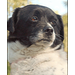
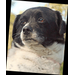
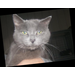
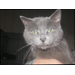
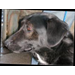
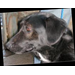
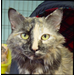
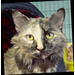

In [52]:
import 	"github.com/gomlx/gomlx/types/slices"

%% --batch=4 --model=byol --byol_use_pairs
config := buildConfig()

trainDS, _, _ := dogsvscats.CreateDatasets(config)

_, inputsT, labelsT, err := trainDS.Yield()
AssertNoError(err)
if len(inputsT) < 2 {
    fmt.Println("Pairs not being generated!?")
    return
}

// Get indices and labels of the images.
labelsFloat := labelsT[0].Local().Value().([]float32)
labels := slices.Map(labelsFloat, func (l float32) dogsvscats.DorOrCat {
    return dogsvscats.DorOrCat(l)
})

// Convert images from tensor to Go images.
imagesA, err := timage.ToImage().Batch(inputsT[0].Local())
AssertNoError(err)
imagesB, err := timage.ToImage().Batch(inputsT[1].Local())
AssertNoError(err)

numRows := *flagBatchSize
htmlRows := make([]string, 0, numRows)
for row := 0; row < numRows; row += 1 {
    cells := []string{
        embedImageInHTML(imagesA[row], labels[row].String(), 0, 64),
        embedImageInHTML(imagesB[row], labels[row].String(), 0, 64),
    }
    htmlRows = append(htmlRows, fmt.Sprintf("<tr>\n\t<td>%s</td>\n</tr>", strings.Join(cells, "</td>\n\t<td>")))
}
htmlTable := fmt.Sprintf("<h3>%s</h3><table>%s</table>\n", "Pairs Of Dogs And Cats", strings.Join(htmlRows, ""))
gonbui.DisplayHTML(htmlTable)

### BYOL Model

BYOL is used on top of some base model, which defaults to our previous CNN model (
but can be configured to the InceptionV3 by setting `--byol_inceptionv3`).

                                                                                  

In [59]:
var flagByolOnlyPrediction = flag.Bool("byol_only_prediction", false, "Train only the prediction, and not the regularization.")

// Include it as a model type.
func init_byol() {
    modelTypeToModelFn["byol"] = ByolCnnModelGraph
}

// byolModel is the core of the BYOL model.
// It's built twice, once for the "online" model once for the "target" model -- using contexts on different scopes.
func byolModel(ctx *context.Context, images *Node) (logit, embeddings *Node) {
	isInceptionV3 := context.GetParamOr(ctx, "byol_inception", false)
	if isInceptionV3 {
		channelsConfig := timage.ChannelsLast
		images = inceptionv3.PreprocessImage(images, 1.0, channelsConfig) // Adjust image to format used by Inception.
		logits := inceptionv3.BuildGraph(ctx, images).
			SetPooling(inceptionv3.MaxPooling).
			Trainable(true).Done()
		embeddings = FnnOnTop(ctx, logits)
	} else {
		// Simple CNN model -- we need an extra FNN on top, so we discard the original predicition.
		_, embeddings = CnnModelWithEmbedding(ctx, images)
	}
	if *flagByolOnlyPrediction {
		embeddings = StopGradient(embeddings)
	}

	ctxPrediction := ctx.In("prediction_layers")
	predictionLayers := FnnOnTop(ctxPrediction, embeddings)
	logit = layers.DenseWithBias(ctxPrediction.In("readout"), predictionLayers, 1)
	return
}

// ByolCnnModelGraph builds a BYOL-version of the CNN model of our demo.
//
// It returns the logit, not the predictions, which works with most losses.
// inputs: only one tensor, with shape `[batch_size, width, height, depth]`.
func ByolCnnModelGraph(ctx *context.Context, spec any, inputs []*Node) []*Node {
	// Create two models: same structure, different initializations, and if `--byol_use_pairs` is set,
	// different augmentations of the same image.
	onlineCtx := ctx.In("online")
	targetCtx := ctx.In("target")
	usePairs := context.GetParamOr(ctx, "byol_use_pairs", false)
	regularizationRate := context.GetParamOr(targetCtx, "byol_regularization_rate", 0.1)

	// Evaluation/Inference we only use the "online" model, and return its prediction.
	// There are no image pairs for inference, even if it's enabled.
	g := inputs[0].Graph() // Graph.
	if !ctx.IsTraining(g) {
		onlineCtx := ctx.In("online")
		onlineLogit, _ := byolModel(onlineCtx, inputs[0])
		return []*Node{onlineLogit} // Return only the logits.
	}

	// If using image pairs, let's say images A and B, we want the model applied twice, and the
	// prediction to be the mean prediction `(online(A)+online(B))/2`.
	numFlips := 1
	if usePairs {
		numFlips = 2
	}
	var prediction *Node

	for flip := 0; flip < numFlips; flip++ {
		// "Online" model is the one that we'll take the predictions from.
		if flip > 0 {
			onlineCtx = onlineCtx.Reuse()
		}
		onlineLogit, onlineEmbedding := byolModel(onlineCtx, inputs[0])
		if prediction == nil {
			// 1st prediction.
			prediction = onlineLogit
		} else {
			// 2nd prediction: take the mean.
			prediction = MulScalar(Add(prediction, onlineLogit), 0.5)
		}

		onlineProjection := byolProjection(onlineCtx, onlineEmbedding)
		onlineTargetPrediction := layers.Dense(onlineCtx.In("online_target_prediction"), onlineProjection, true,
			context.GetParamOr(onlineCtx, "byol_num_nodes", 0))
		onlineTargetPrediction = L2NormalizeWithEpsilon(onlineTargetPrediction, 1e-12, -1)

		// "Target" model is the one used to regularize, and is updated by a moving
		// average towards the "Online" model.
		if usePairs {
			// Flip inputs for target:
			inputs[0], inputs[1] = inputs[1], inputs[0]
		}
		if *flagByolOnlyPrediction || regularizationRate <= 0.0 {
			continue
		}
		if flip > 0 {
			targetCtx = targetCtx.Reuse()
		}
		targetCtx.SetParam("conv_dropout", 0.0) // Disable dropout on the target side.
		_, targetEmbedding := byolModel(targetCtx, inputs[0])
		targetProjection := byolProjection(targetCtx, targetEmbedding)
		targetProjection = L2NormalizeWithEpsilon(targetProjection, 1e-12, -1)

		// Gradient descent does not update the "target" model, so we `StopGradient` and mark their
		// variables as not training.
		targetProjection = StopGradient(targetProjection)
		if flip == 0 {
			targetCtx.EnumerateVariablesInScope(func(v *context.Variable) {
				v.Trainable = false
			})
		}

		// Add a loss term regularizing the "online" model projection towards the "target" one.
		targetRegularization := L2NormSquare(Sub(onlineTargetPrediction, targetProjection), -1)
		if usePairs {
			targetRegularization = MulScalar(targetRegularization, 0.5)
		}
		//train.AddLoss(ctx, targetRegularization)
		train.AddLoss(ctx, MulScalar(targetRegularization, regularizationRate))
	}

	// Update "target" model with moving average to the "online" model.
	movingAverageRatio := context.GetParamOr(targetCtx, "byol_target_update_ratio", 0.999)
	if movingAverageRatio < 1.0 && !*flagByolOnlyPrediction && regularizationRate > 0.0 {
		onlineScope := onlineCtx.Scope()
		targetScope := targetCtx.Scope()
		targetCtx.EnumerateVariablesInScope(func(targetVar *context.Variable) {
			if !strings.HasPrefix(targetVar.Scope(), targetScope) {
				exceptions.Panicf("BYOL target model variable %q::%q has unexpected scope (not prefixed with %q)",
					targetVar.Scope(), targetVar.Name(), targetScope)
			}

			// Get corresponding variable in "online" model.
			onlineVarScope := onlineScope + targetVar.Scope()[len(targetScope):]
			onlineVar := ctx.InspectVariable(onlineVarScope, targetVar.Name())
			if onlineVar == nil {
				exceptions.Panicf("BYOL target model variable %q::%q has no corresponding variable %q::%q in online model",
					targetVar.Scope(), targetVar.Name(), onlineVarScope, targetVar.Name())
			}

			targetValue := targetVar.ValueGraph(g)
			onlineValue := onlineVar.ValueGraph(g)
			targetValue = Add(
				MulScalar(onlineValue, 1.0-movingAverageRatio),
				MulScalar(targetValue, movingAverageRatio))
			targetVar.SetValueGraph(targetValue)
		})
	}
	return []*Node{prediction} // Return only the logits.
}

func byolProjection(ctx *context.Context, embeddings *Node) *Node {
	// Re-use FnnOnTop: redefine its params based on BYOL ones, in the local scope.
	ctx = ctx.In("byol_projection")
	numLayers := context.GetParamOr(ctx, "byol_hidden_layers", 2)
	if numLayers == 0 {
		return embeddings
	}
	ctx.SetParam("hidden_layers", numLayers)
	numNodes := context.GetParamOr(ctx, "byol_num_nodes", 0)
	ctx.SetParam("num_nodes", numNodes)
	return FnnOnTop(ctx, embeddings)
}

%% --steps=100 --model=byol --plots=false
config := buildConfig()
trainModel(config)


2023-11-24 14:48:05.452657: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-11-24 14:48:05.457407: E external/xla/xla/stream_executor/stream_executor_internal.h:182] SetPriority unimplemented for this stream.


Training (100 steps):  100% [========================================] (4 steps/s) [loss=5.128] [~loss=19.564] [~acc=53.91%]        
	[Step 100] median train step: 175027 microseconds

Results on train-eval [Pre]:
	Mean Loss (#loss): 0.688
	Mean Accuracy (#acc): 54.17%
Results on valid-eval [Pre]:
	Mean Loss (#loss): 0.686
	Mean Accuracy (#acc): 55.26%



### Training BYOL model with 30K steps

In [54]:
!rm -rf ~/tmp/dogs_vs_cats/byol_base

In [56]:
// %% --steps=30000 --model=byol --checkpoint=byol_base --byol_regularization_rate=31 --unsupervised
// %% --steps=30000 --model=byol --checkpoint=byol_base --byol_only_prediction
%% --steps=30000 --model=byol --checkpoint=byol_base --byol_regularization_rate=1 --hidden_layers=4
config := buildConfig()
trainModel(config)

> restarting training from global_step=30000


Training (30000 steps):  100% [========================================] (94 steps/s) [loss=0.202] [~loss=0.248] [~acc=93.67%]          


<path vector-effect="non-scaling-stroke" d="M1.768000e+01,1.046002e+01 L1.161081e+02,4.024166e+01 L1.764715e+02,4.927019e+01 L2.212808e+02,5.293806e+01 L2.575742e+02,7.873833e+01 L2.886479e+02,8.833118e+01 L3.160650e+02,8.152840e+01 L3.408807e+02,9.011807e+01 L3.637461e+02,6.704514e+01 L3.850865e+02,1.035668e+02 L4.051917e+02,1.094291e+02 L4.242665e+02,1.222195e+02 L4.425141e+02,1.267651e+02 L4.600736e+02,1.231914e+02 L4.770419e+02,1.332544e+02 L4.934874e+02,1.214985e+02 L5.094920e+02,1.413111e+02 L5.251103e+02,1.477377e+02 L5.404042e+02,1.463583e+02 L5.554120e+02,1.558571e+02 L5.701773e+02,1.526595e+02 L5.847245e+02,1.570797e+02 L5.990819e+02,1.669233e+02 L6.132632e+02,1.692432e+02 L6.272853e+02,1.733499e+02 L6.411663e+02,1.761713e+02 L6.549228e+02,1.798078e+02 L6.685691e+02,1.822217e+02 L6.821170e+02,1.835383e+02 L6.955749e+02,1.846669e+02 L7.089560e+02,1.949808e+02 L7.222680e+02,2.008431e+02 L7.355139e+02,2.063291e+02 L7.487044e+02,1.828487e+02 L7.618433e+02,1.981471e+02 L7.743646e+02,2.139470e+02 L7.749338e+02,2.170505e+02 L7.879821e+02,2.217215e+02 L8.009911e+02,2.255461e+02 L8.139677e+02,2.304993e+02 L8.269140e+02,2.219097e+02 L8.398336e+02,2.391830e+02 L8.527276e+02,2.452647e+02 L8.655995e+02,2.486818e+02 L8.663200e+02,2.504687e+02 "/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,1.753157e+01 L1.161081e+02,4.112742e+01 L1.764715e+02,5.600890e+01 L2.212808e+02,5.694736e+01 L2.575742e+02,7.182885e+01 L2.886479e+02,8.416305e+01 L3.160650e+02,7.316951e+01 L3.408807e+02,8.416305e+01 L3.637461e+02,6.083532e+01 L3.850865e+02,9.931266e+01 L4.051917e+02,1.023962e+02 L4.242665e+02,1.190206e+02 L4.425141e+02,1.262602e+02 L4.600736e+02,1.180821e+02 L4.770419e+02,1.286734e+02 L4.934874e+02,1.147304e+02 L5.094920e+02,1.398010e+02 L5.251103e+02,1.435549e+02 L5.404042e+02,1.408736e+02 L5.554120e+02,1.524034e+02 L5.701773e+02,1.521352e+02 L5.847245e+02,1.521352e+02 L5.990819e+02,1.605815e+02 L6.132632e+02,1.620562e+02 L6.272853e+02,1.691618e+02 L6.411663e+02,1.719772e+02 L6.549228e+02,1.723794e+02 L6.685691e+02,1.730497e+02 L6.821170e+02,1.764014e+02 L6.955749e+02,1.686255e+02 L7.089560e+02,1.805575e+02 L7.222680e+02,1.781443e+02 L7.355139e+02,1.873949e+02 L7.487044e+02,1.644694e+02 L7.618433e+02,1.718431e+02 L7.743646e+02,1.853839e+02 L7.749338e+02,1.849817e+02 L7.879821e+02,1.896741e+02 L8.009911e+02,1.939642e+02 L8.139677e+02,1.971819e+02 L8.269140e+02,1.857862e+02 L8.398336e+02,1.924895e+02 L8.527276e+02,1.928917e+02 L8.655995e+02,1.963775e+02 L8.663200e+02,1.926236e+02 "/> <path d="M1.768000e+01,5.200000e+00 L1.161081e+02,2.777413e+01 L1.764715e+02,5.095290e+01 L2.212808e+02,7.059800e+01 L2.575742e+02,8.996709e+01 L2.886479e+02,9.198489e+01 L3.160650e+02,1.059012e+02 L3.408807e+02,1.062393e+02 L3.637461e+02,1.181865e+02 L3.850865e+02,1.198764e+02 L4.051917e+02,1.220412e+02 L4.242665e+02,1.302784e+02 L4.425141e+02,1.341840e+02 L4.600736e+02,1.371525e+02 L4.770419e+02,1.447190e+02 L4.934874e+02,1.436515e+02 L5.094920e+02,1.515129e+02 L5.251103e+02,1.478926e+02 L5.404042e+02,1.602831e+02 L5.554120e+02,1.617643e+02 L5.701773e+02,1.671637e+02 L5.847245e+02,1.667334e+02 L5.990819e+02,1.706227e+02 L6.132632e+02,1.742180e+02 L6.272853e+02,1.802397e+02 L6.411663e+02,1.848274e+02 L6.549228e+02,1.882136e+02 L6.685691e+02,1.873854e+02 L6.821170e+02,1.944797e+02 L6.955749e+02,1.952679e+02 L7.089560e+02,2.011719e+02 L7.222680e+02,2.060409e+02 L7.355139e+02,2.095362e+02 L7.487044e+02,2.138316e+02 L7.618433e+02,2.161798e+02 L7.743646e+02,2.169963e+02 L7.749338e+02,2.248863e+02 L7.879821e+02,2.280606e+02 L8.009911e+02,2.303197e+02 L8.139677e+02,2.336340e+02 L8.269140e+02,2.378393e+02 L8.398336e+02,2.455889e+02 L8.527276e+02,2.480469e+02 L8.655995e+02,2.548000e+02 L8.663200e+02,2.507122e+02 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.096354e+02,0 L1.096354e+02,-6 M1.634259e+02,0 L1.634259e+02,-6 M2.015909e+02,0 L2.015909e+02,-6 M2.311939e+02,0 L2.311939e+02,-6 M2

<path vector-effect="non-scaling-stroke" d="M1.768000e+01,2.411240e+02 L1.161081e+02,2.312203e+02 L1.764715e+02,2.322764e+02 L2.212808e+02,2.322105e+02 L2.575742e+02,2.141116e+02 L2.886479e+02,2.048184e+02 L3.160650e+02,2.157762e+02 L3.408807e+02,2.066441e+02 L3.637461e+02,2.493442e+02 L3.850865e+02,1.945940e+02 L4.051917e+02,1.836293e+02 L4.242665e+02,1.717541e+02 L4.425141e+02,1.666246e+02 L4.600736e+02,1.713020e+02 L4.770419e+02,1.630039e+02 L4.934874e+02,1.761167e+02 L5.094920e+02,1.500753e+02 L5.251103e+02,1.434617e+02 L5.404042e+02,1.475852e+02 L5.554120e+02,1.342503e+02 L5.701773e+02,1.424258e+02 L5.847245e+02,1.315910e+02 L5.990819e+02,1.202292e+02 L6.132632e+02,1.175496e+02 L6.272853e+02,1.164610e+02 L6.411663e+02,1.108316e+02 L6.549228e+02,1.053568e+02 L6.685691e+02,1.005873e+02 L6.821170e+02,1.005506e+02 L6.955749e+02,9.904321e+01 L7.089560e+02,9.059902e+01 L7.222680e+02,7.381027e+01 L7.355139e+02,6.873094e+01 L7.487044e+02,1.090219e+02 L7.618433e+02,8.420106e+01 L7.743646e+02,5.813997e+01 L7.749338e+02,4.708836e+01 L7.879821e+02,4.213865e+01 L8.009911e+02,3.997180e+01 L8.139677e+02,3.449387e+01 L8.269140e+02,5.115724e+01 L8.398336e+02,2.170037e+01 L8.527276e+02,1.017882e+01 L8.655995e+02,9.293510e+00 L8.663200e+02,5.200000e+00 "/> <path d="M1.768000e+01,2.395853e+02 L1.161081e+02,2.303000e+02 L1.764715e+02,2.310588e+02 L2.212808e+02,2.316596e+02 L2.575742e+02,2.148014e+02 L2.886479e+02,2.073857e+02 L3.160650e+02,2.184979e+02 L3.408807e+02,2.101688e+02 L3.637461e+02,2.548000e+02 L3.850865e+02,1.997238e+02 L4.051917e+02,1.874625e+02 L4.242665e+02,1.754845e+02 L4.425141e+02,1.724819e+02 L4.600736e+02,1.759042e+02 L4.770419e+02,1.697965e+02 L4.934874e+02,1.821169e+02 L5.094920e+02,1.573892e+02 L5.251103e+02,1.508960e+02 L5.404042e+02,1.558267e+02 L5.554120e+02,1.449016e+02 L5.701773e+02,1.505079e+02 L5.847245e+02,1.442321e+02 L5.990819e+02,1.317636e+02 L6.132632e+02,1.300985e+02 L6.272853e+02,1.285981e+02 L6.411663e+02,1.254931e+02 L6.549228e+02,1.212229e+02 L6.685691e+02,1.229432e+02 L6.821170e+02,1.221286e+02 L6.955749e+02,1.243539e+02 L7.089560e+02,1.213680e+02 L7.222680e+02,1.111871e+02 L7.355139e+02,1.134797e+02 L7.487044e+02,1.578350e+02 L7.618433e+02,1.446589e+02 L7.743646e+02,1.267350e+02 L7.749338e+02,1.157947e+02 L7.879821e+02,1.190399e+02 L8.009911e+02,1.240318e+02 L8.139677e+02,1.338327e+02 L8.269140e+02,1.616257e+02 L8.398336e+02,1.693473e+02 L8.527276e+02,1.805837e+02 L8.655995e+02,2.193145e+02 L8.663200e+02,2.210307e+02 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.096354e+02,0 L1.096354e+02,-6 M1.634259e+02,0 L1.634259e+02,-6 M2.015909e+02,0 L2.015909e+02,-6 M2.311939e+02,0 L2.311939e+02,-6 M2.553813e+02,0 L2.553813e+02,-6 M2.758315e+02,0 L2.758315e+02,-6 M2.935463e+02,0 L2.935463e+02,-6 M3.091718e+02,0 L3.091718e+02,-6 M3.231493e+02,0 L3.231493e+02,-6 M3.357935e+02,0 L3.357935e+02,-6 M4.151048e+02,0 L4.151048e+02,-6 M4.688952e+02,0 L4.688952e+02,-6 M5.070602e+02,0 L5.070602e+02,-6 M5.366632e+02,0 L5.366632e+02,-6 M5.608507e+02,0 L5.608507e+02,-6 M5.813009e+02,0 L5.813009e+02,-6 M5.990156e+02,0 L5.990156e+02,-6 M6.146411e+02,0 L6.146411e+02,-6 M6.286187e+02,0 L6.286187e+02,-6 M7.205741e+02,0 L7.205741e+02,-6 M7.743646e+02,0 L7.743646e+02,-6 M8.125295e+02,0 L8.125295e+02,-6 M8.421326e+02,0 L8.421326e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 "/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 20000 30000 40000 50000 60000 Steps 0.200 0.400 0.600 eval-loss eval-loss metrics Eval on train-eval [Pre]: Mean Loss Eval on valid-eval [Pre]: Mean Loss

<path d="M1.768000e+01,2.548000e+02 L1.161081e+02,1.633686e+02 L1.764715e+02,1.198515e+02 L2.212808e+02,1.011768e+02 L2.575742e+02,9.044732e+01 L2.886479e+02,8.736097e+01 L3.160650e+02,8.293035e+01 L3.408807e+02,8.095900e+01 L3.637461e+02,7.559249e+01 L3.850865e+02,7.515842e+01 L4.051917e+02,7.433415e+01 L4.242665e+02,6.986952e+01 L4.425141e+02,6.966123e+01 L4.600736e+02,6.542954e+01 L4.770419e+02,6.138399e+01 L4.934874e+02,6.244495e+01 L5.094920e+02,6.042381e+01 L5.251103e+02,6.096603e+01 L5.404042e+02,5.665216e+01 L5.554120e+02,5.521812e+01 L5.701773e+02,5.384644e+01 L5.847245e+02,5.369564e+01 L5.990819e+02,5.497443e+01 L6.132632e+02,5.658094e+01 L6.272853e+02,5.417279e+01 L6.411663e+02,5.333361e+01 L6.549228e+02,5.104190e+01 L6.685691e+02,5.177511e+01 L6.821170e+02,5.141742e+01 L6.955749e+02,5.097441e+01 L7.089560e+02,4.658670e+01 L7.222680e+02,4.544671e+01 L7.355139e+02,4.435963e+01 L7.487044e+02,3.795712e+01 L7.618433e+02,3.502809e+01 L7.743646e+02,3.615173e+01 L7.749338e+02,3.068434e+01 L7.879821e+02,2.793283e+01 L8.009911e+02,2.375917e+01 L8.139677e+02,2.150984e+01 L8.269140e+02,1.813045e+01 L8.398336e+02,1.188393e+01 L8.527276e+02,9.556814e+00 L8.655995e+02,5.200000e+00 L8.663200e+02,5.740388e+00 " vector-effect="non-scaling-stroke"/> <path vector-effect="non-scaling-stroke" d="M1.768000e+01,0 L1.768000e+01,-6 M1.096354e+02,0 L1.096354e+02,-6 M1.634259e+02,0 L1.634259e+02,-6 M2.015909e+02,0 L2.015909e+02,-6 M2.311939e+02,0 L2.311939e+02,-6 M2.553813e+02,0 L2.553813e+02,-6 M2.758315e+02,0 L2.758315e+02,-6 M2.935463e+02,0 L2.935463e+02,-6 M3.091718e+02,0 L3.091718e+02,-6 M3.231493e+02,0 L3.231493e+02,-6 M3.357935e+02,0 L3.357935e+02,-6 M4.151048e+02,0 L4.151048e+02,-6 M4.688952e+02,0 L4.688952e+02,-6 M5.070602e+02,0 L5.070602e+02,-6 M5.366632e+02,0 L5.366632e+02,-6 M5.608507e+02,0 L5.608507e+02,-6 M5.813009e+02,0 L5.813009e+02,-6 M5.990156e+02,0 L5.990156e+02,-6 M6.146411e+02,0 L6.146411e+02,-6 M6.286187e+02,0 L6.286187e+02,-6 M7.205741e+02,0 L7.205741e+02,-6 M7.743646e+02,0 L7.743646e+02,-6 M8.125295e+02,0 L8.125295e+02,-6 M8.421326e+02,0 L8.421326e+02,-6 M8.663200e+02,0 L8.663200e+02,-6 "/> 100 200 300 400 500 600 700 800 900 1000 1100 2000 3000 4000 5000 6000 7000 8000 9000 10000 20000 30000 40000 50000 60000 Steps 0.300 0.600 0.900 1.200 loss loss metrics Train: Moving Average Loss

	[Step 60000] median train step: 8917 microseconds

Results on train-eval [Pre]:
	Mean Loss (#loss): 0.180
	Mean Accuracy (#acc): 93.63%
Results on valid-eval [Pre]:
	Mean Loss (#loss): 0.639
	Mean Accuracy (#acc): 84.45%



### Results from multiple runs:

| Try | Train <br/> Loss | Train <br/> Accuracy | Validation <br/> Loss | Validation <br/> Accuracy |
| --- | --- | --- | --- | --- |
| 1 | 0.225 | 90.56% | 0.423 | 82.47% |
| 2 | 0.221 | 90.79% | 0.441 | 82.53% |
| 3 | 0.192 | 92.13% | 0.426 | 83.28% |
| 4 | 0.211 | 91.30% | 0.432 | 82.40% |
| 5 | 0.191 | 92.20% | 0.447 | 82.70% |
| 6 | 0.205 | 91.47% | 0.443 | 82.09% |
| 7 | 0.198 | 91.94% | 0.428 | 83.15% |
| 8 | 0.185 | 92.64% | 0.423 | 84.06% |
| 9 | 0.219 | 90.88% | 0.431 | 82.43% |
| 10 | 0.206 | 91.48% | 0.440 | 82.62% |

